# terms
$\Lambda$ : Hyperparameter \
$\theta$ : Param of single distribution \
for eg $\mu$ : Mean of the distribution or $\sigma$ : variance of distribution \
$X$ : DATA \
$Z$: Evidence

For changing distribution of $\lambda$ https://docs.scipy.org/doc/scipy/reference/stats.html

Some helpful resources : https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html, https://docs.exoplanet.codes/en/latest/tutorials/intro-to-pymc3/, https://boyangzhao.github.io/posts/mcmc-bayesian-inference

https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html



Solving $ P(\Lambda|X,\mu)$ using Bayes th. 

$ P(\Lambda|X,\mu) =\frac{P(X,\mu|\Lambda)\pi(\Lambda)}{Z}=\frac{P(X|\mu,\Lambda)\pi(\mu|\Lambda)\pi(\Lambda)}{Z}$

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import arviz as az

# Case 1 : Estimating mean ($\Lambda$) of a Gaussian distribution in a HM

Text(0.5, 1.0, '$\\mathcal{N}(\\Lambda=3,1)$')

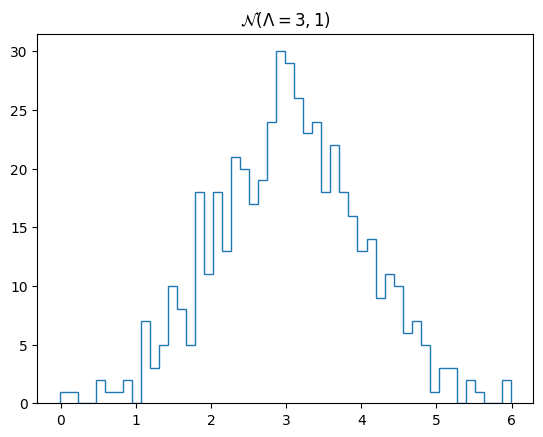

In [2]:
LEN_DATA = 500 # size of X
SIZE = 500 # number of points on the distribution
LAMBDA = 3 # mu here
DIST = st.norm(loc=LAMBDA, scale=1).rvs(size=SIZE) # hyperparameter is governed by a gaussian function

plt.hist(DIST, bins=50, fill=False, histtype='step')
plt.title(r'$\mathcal{N}(\Lambda=3,1)$')

In [3]:
X = np.empty((SIZE, LEN_DATA))
for i in range(SIZE):
    
    # Note here the std. dev of the X's is small. Large std. dev would lead
    # to incorrect estimation of "MU". For eg. std. dev of 1 would lead to 
    # MU ~ 1.5.
    
    X[i] = st.norm(loc=DIST[i], scale=0.5).rvs(size=LEN_DATA) 

Text(0, 0.5, '$X=\\mathcal{N}(\\mu,0.5)$')

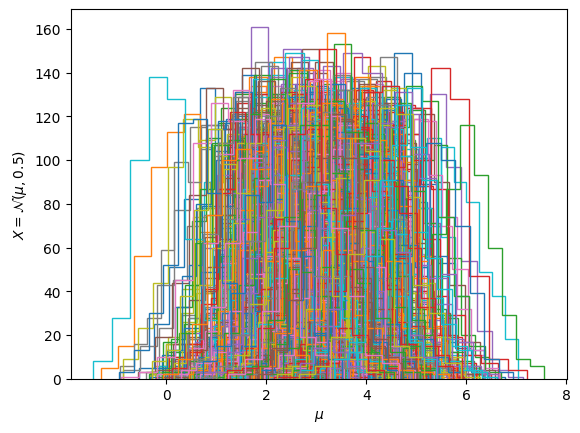

In [4]:
for i in range(SIZE):
    plt.hist(X[i], fill=False, histtype='step', label=i)
plt.xlabel('$\mu$')
plt.ylabel('$X=\mathcal{N}(\mu,0.5)$')

In [5]:
import pymc3 as pm

In [6]:
with pm.Model() as model:

    hyperprior = pm.Uniform('MU', lower=1, upper=5)  # hyperprior
    prior = pm.Normal('mu', mu=hyperprior, sigma=1)  # prior draws data points from hyperprior
    obs = pm.Normal('obs', mu=prior, sigma=0.5, observed=X)  # likelihood draws data points from prior

    # sample with 3 independent Markov chains
    trace_NUTS = pm.sample(draws=500, chains=3, step=pm.NUTS(), return_inferencedata=True, cores=2)
    trace_METROPOLIS= pm.sample(draws=500, chains=3, step=pm.Metropolis(), return_inferencedata=True, cores=2)

Multiprocess sampling (3 chains in 2 jobs)
NUTS: [mu, MU]


Sampling 3 chains for 1_000 tune and 500 draw iterations (3_000 + 1_500 draws total) took 16 seconds.
Multiprocess sampling (3 chains in 2 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [MU]


/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 3 chains for 1_000 tune and 500 draw iterations (3_000 + 1_500 draws total) took 2 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<Axes: title={'center': 'MU'}>, <Axes: title={'center': 'MU'}>]],
      dtype=object)

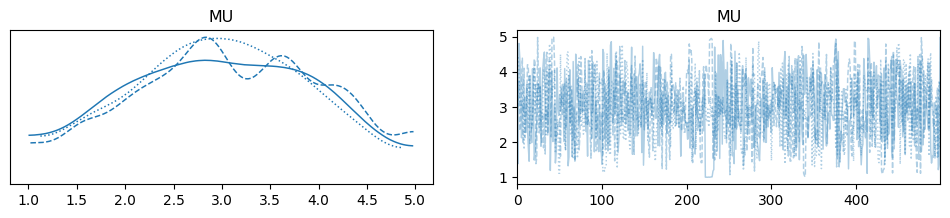

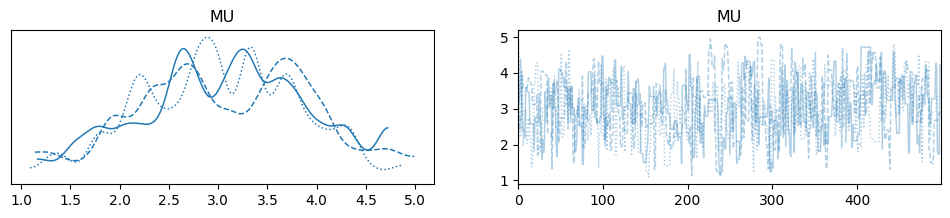

In [7]:
az.plot_trace(trace_NUTS, var_names=('MU'), )
az.plot_trace(trace_METROPOLIS, var_names=('MU'))

In [9]:
az.summary(trace_NUTS, var_names=["MU"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
MU,3.006,0.916,1.356,4.58,0.028,0.02,926.0,578.0,1.0


In [10]:
az.summary(trace_METROPOLIS, var_names=["MU"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
MU,3.05,0.818,1.402,4.417,0.043,0.031,364.0,357.0,1.01


# Estimating mean ($\Lambda$) & scale ($\sigma$) of a Gaussian distribution in a HM

Text(0.5, 1.0, '$\\mathcal{N}(\\lambda_1=2,\\lambda_2=0.5)$')

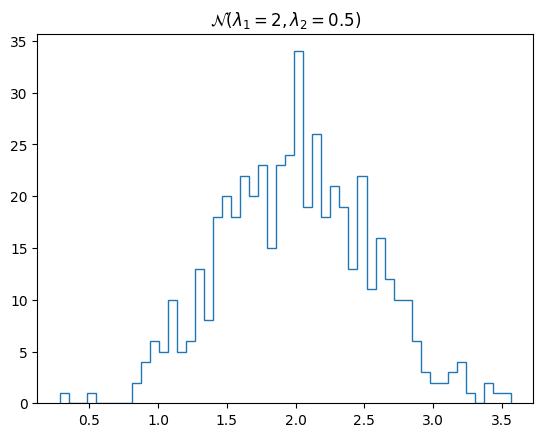

In [2]:
LEN_DATA = 100 # size of X
SIZE = 500 # mu in this case 
LAMBDA = [2,.5]
DIST = st.norm(loc=LAMBDA[0], scale=LAMBDA[1]).rvs(size=SIZE) 
plt.hist(DIST, bins=50, fill=False, histtype='step')
plt.title(r'$\mathcal{N}(\lambda_1=2,\lambda_2=0.5)$')

In [3]:
X = np.empty((SIZE, LEN_DATA))
for i in range(SIZE):
    X[i] = st.norm(loc=DIST[i], scale=0.5).rvs(size=LEN_DATA)

Text(0, 0.5, '$X=\\mathcal{N}(\\mu,0.5)$')

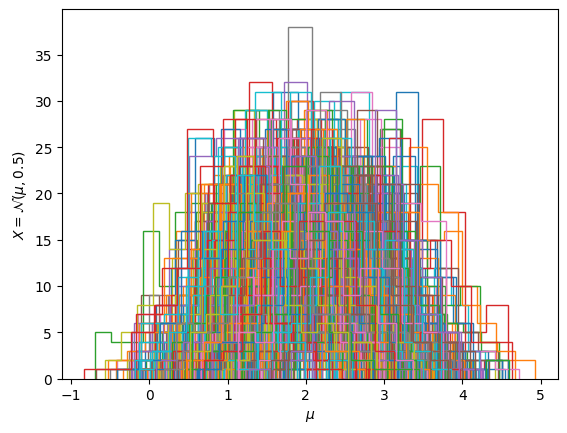

In [4]:
# large number of data sets can lead to a messy plot
for i in range(SIZE):
    plt.hist(X[i], fill=False, histtype='step', label=i)
plt.xlabel('$\mu$')
plt.ylabel('$X=\mathcal{N}(\mu,0.5)$')

In [5]:
import pymc3 as pm

In [6]:
with pm.Model() as model:

    MU = pm.Uniform('MU', lower=0, upper=5)
    SIGMA = pm.Uniform('SIGMA', lower=0, upper=1)
    hyperprior = pm.Normal('hP', mu=MU, sigma=SIGMA)  # hyperprior
    prior = pm.Normal('mu', mu=hyperprior, sigma=1)  # prior draws data points from hyperprior
    obs = pm.Normal('obs', mu=prior, sigma=0.5, observed=X)  # likelihood draws data points from prior

    # sample with 3 independent Markov chains
    trace_METROPOLIS = pm.sample(draws=500, chains=3, step=pm.Metropolis(), return_inferencedata=True)
    trace_NUTS = pm.sample(draws=500, chains=3, step=pm.NUTS(), return_inferencedata=True)

Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [hP]
>Metropolis: [SIGMA]
>Metropolis: [MU]


/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 3 chains for 1_000 tune and 500 draw iterations (3_000 + 1_500 draws total) took 1 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [mu, hP, SIGMA, MU]


Sampling 3 chains for 1_000 tune and 500 draw iterations (3_000 + 1_500 draws total) took 4 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7081501166186365, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<Axes: title={'center': 'MU'}>, <Axes: title={'center': 'MU'}>],
       [<Axes: title={'center': 'SIGMA'}>,
        <Axes: title={'center': 'SIGMA'}>]], dtype=object)

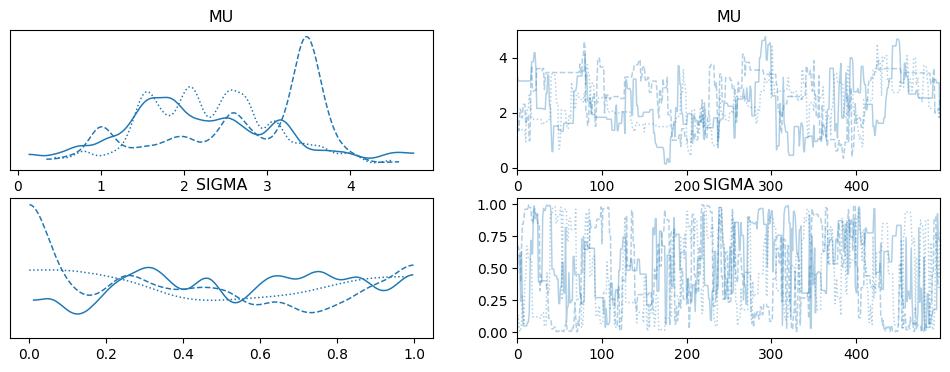

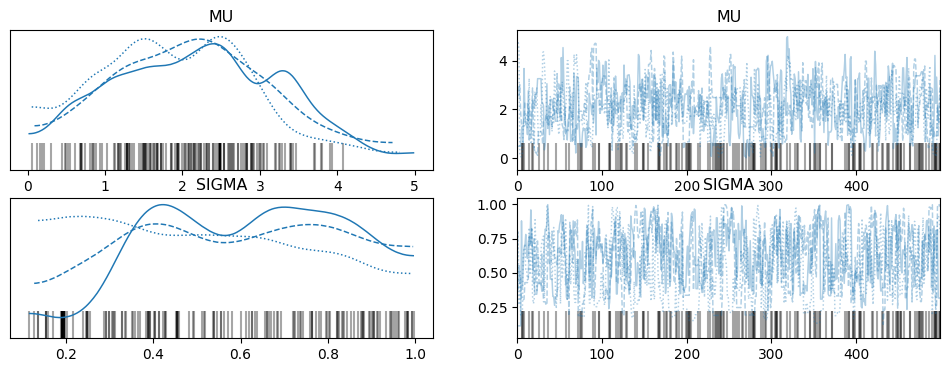

In [7]:
az.plot_trace(trace_METROPOLIS, var_names=('MU', 'SIGMA'))
az.plot_trace(trace_NUTS, var_names=('MU', 'SIGMA'))

In [8]:
az.summary(trace_NUTS, var_names=["MU", "SIGMA"])["mean"]

MU       2.076
SIGMA    0.576
Name: mean, dtype: float64

In [9]:
az.summary(trace_METROPOLIS, var_names=["MU", "SIGMA"])["mean"]

MU       2.409
SIGMA    0.482
Name: mean, dtype: float64

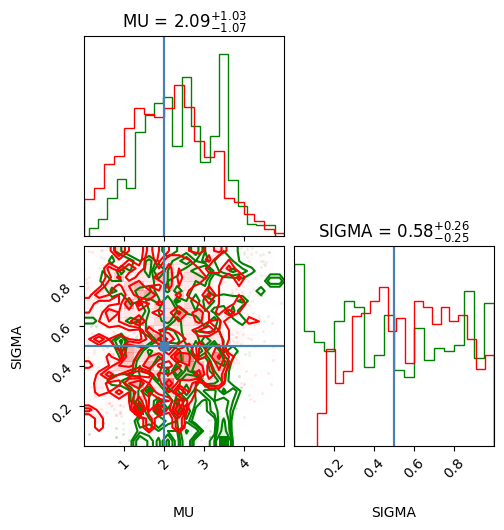

In [10]:
import corner
fig = corner.corner(trace_METROPOLIS, color='green', var_names=["MU", "SIGMA"], truths=dict(MU=2, SIGMA=.5), show_titles=True)
_ = corner.corner(trace_NUTS, fig=fig, color='red', label='NUTS', var_names=["MU", "SIGMA"], truths=dict(MU=2, SIGMA=.5), show_titles=True)